# Gaussian processes like you never saw them

I understood what Gaussian processes were when I saw David MacKay [explaining them](http://videolectures.net/gpip06_mackay_gpb/).
Last summer, at the EPRV III, I used the same explanation for a room full of astronomers and a lot of people told me it finally had clicked for them too.

Another thing I remember from MacKay's lecture is that the samples he shows in his movies seem to behave quite well and are not jumping around all the time. When asked this (around the 16min mark), MacKay says he "introduced correlations" in the samples to make them look more visually appealing. I sort of understood that at the time, but didn't know how to do it myself.

Very recently, I came across [this](http://www.tmpl.fi/gp/) incredible demo of Gaussian process regression, written by Tomi Peltola. And if you keep reading this post before visiting that link, I will show you GPs like you (probably) never saw them before.


## TL;DR

We will use Hamiltonian Monte Carlo (kind of)
to go through a _trajectory_ within a multivariate Gaussian distribution.
This gives us _continuous_ samples from a GP.


## the setup

First we need some imports, to be able to animate a plot with matplotlib,
and see it playing inside the notebook directly.

In [1]:
#%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='html5')

For all GP-related calculations, we will use the excellent `george` package,
written by Daniel Foreman-Mackey.

In [2]:
# george 0.2.1
from george import GP
from george.kernels import *

`george` gives us with a bunch of covariance functions, or kernels, to build our GP:

In [3]:
[k for k in dir() if 'Kernel' in k]

['ConstantKernel',
 'CosineKernel',
 'DotProductKernel',
 'ExpKernel',
 'ExpSine2Kernel',
 'ExpSquaredKernel',
 'Kernel',
 'Matern32Kernel',
 'Matern52Kernel',
 'PythonKernel',
 'RadialKernel',
 'WhiteKernel']

but we will start simple with a squared exponential

In [4]:
kernel = ExpSquaredKernel(1.)

We also define our input space

In [5]:
x = np.linspace(-5, 5, 200)

## Hamiltonian Monte Carlo

Now the fun part!

Hamiltonian Monte Carlo is a very cool sampling algorithm.
Think of it as an MCMC sampler that knows exactly where to go.
The algorithm uses Hamiltonian dynamics to produce proposals
which avoid the slow exploration of the parameter space typical of simpler random-walk proposals.

It works by introducing fictitious "momentum" variables,
and by equating the target distribution to the potential term of the Hamiltonian.
For sure I cannot do a better job than Radford Neal, so [read this](https://arxiv.org/abs/1206.1901) for a much better explanation.


For a multivariate Gaussian distribution, Hamilton's equations have an analytical solution. Because Gaussians are awesome, that's why!

The following class implements this solution.
Given a kernel and an input space, it stores a `GP` object, together with two array attributes: `z` and `p`. These are the position and momenta of the Hamiltonian.
Which means that `z` is a sample from the GP. But a sample that evolves!

In [6]:
class GPc(object):
    def __init__(self, kernel, x):
        self.gp = GP(kernel)
        self.stepState = 0
        
        self.z = self.gp.sample(x)
        self.p = self.gp.sample(x) 

    def sample_independent(self, x):
        self.z = self.gp.sample(x)
        return self.z
    
    def sample_continuous(self, x, alpha=0.3, Nsteps=15, stepsize=np.pi):
        alpha = 1. - alpha
        t = stepsize / Nsteps
        self.stepState = self.stepState % Nsteps
        if self.stepState == Nsteps-1: # refresh momentum
            self.p = alpha*self.p + np.sqrt(1-alpha**2)*self.gp.sample(x)
            
        a = self.p; b = self.z; c = -self.z; d = self.p
        self.z = a * np.sin(t) + b * np.cos(t)
        self.p = c * np.sin(t) + d * np.cos(t)
        self.stepState += 1
        return self.z

Let's instantiate a `GPc` object

In [7]:
g = GPc(kernel, x)

/home/joao/anaconda2/lib/python2.7/site-packages/george/utils.py:30: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(mean, matrix, N)


and show GP samples, the old way:

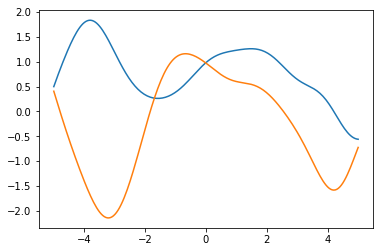

In [8]:
fig, ax = plt.subplots()
ax.plot(x, g.sample_independent(x));
ax.plot(x, g.sample_independent(x));
plt.show()

Now let's see what `sample_continuous` does.

First, we setup the figure to show the mean of the GP (zero) and the 95% credible interval. We set the axes limits and plot empty lists

In [9]:
fig, ax = plt.subplots()
ax.plot(x, g.gp.mean(x), 'b', alpha=0.6)
ax.plot(x, 1.96*np.sqrt(np.diag(g.gp.get_matrix(x))), 'b', alpha=0.4, ls='--');
ax.plot(x, -1.96*np.sqrt(np.diag(g.gp.get_matrix(x))),'b', alpha=0.4, ls='--');
ax.set_xlim((-5, 5))
ax.set_ylim((-4, 4))
line, = ax.plot([], [], lw=2);

We define two functions: `init` plots the first (independent) sample,
and `animate` which updates the plot with a _continuous_ sample.

In [10]:
# initialization function: plot the background of each frame
def init():
    line.set_data(x, g.sample_independent(x))
    return (line,)

# animation function, called sequentially for each frame i
def animate(i):
    line.set_ydata(g.sample_continuous(x))
    return (line,)

In [11]:
# call the animator, blit=True means only re-draw the parts that have changed
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, blit=True);

et voilá

In [12]:
anim

Yes, each of those lines is a (valid) sample from our GP. But the samples are close to the previous one and the next one, in a way that makes the movie appealling.
About 5% of the time, they'll cross the dashed lines.

This is cool, I think. 
But why settle for a 10 second animation when our trajectory basically continues forever?

With the help of `pyqtgraph`, we can do a plot that just keeps running. 
I have no way of showing you this in this page (well just visit Tomi Peltola's [page](http://www.tmpl.fi/gp/)), but run the following code and you will get an independent plot of continuous samples from the GP.
You can keep using the notebook, the plot will just keep updating in the background.

In [ ]:
from pyqtgraph.Qt import QtGui, QtCore
import pyqtgraph as pg
from multiprocessing import Process, Manager

In [ ]:
def f():
    app = QtGui.QApplication([])
    win = pg.GraphicsWindow(title="GP continuous samples")
    p = win.addPlot()
    p.setRange(QtCore.QRectF(-5, -5, 10, 10))
    curve = p.plot(pen='r')
    
    def update(curve):
        curve.setData(x, g.sample_continuous(x, Nsteps=30))
        update.i += 0.2

    update.i = 0

    timer = QtCore.QTimer()
    timer.timeout.connect(lambda: update(curve))
    timer.start(20)

    QtGui.QApplication.instance().exec_()

In [ ]:
manager = Manager()
p = Process(target=f)
p.start()

In [ ]:
print 'still running in the background'